In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [24]:
from pathlib import Path

# Configurable parts
MODEL_NAME = "gru"
SOURCE = "dukascopy"
SYMBOL = "usdjpy"
MINUTES = 1
START_DATE = "2020-01-01"
END_DATE = "2024-12-31"
EVENT_NAME = "cusum_filter"
SEQUENCE_LENGTH = 60
TIME_COLS = [
    # 'timestamp',
    "hour",
    "dow",
    "dom",
    # "month",
    # "open",
    # "high",
    # "low",
    # "close",
]

FEATURES_COLS = [
    # Basic Data
    "close_log_return",
    "log_volume",
    "macd",
    "macd_signal",
    "macd_diff",
]
TARGET_COL = "bin_class"



# Build base name
BASE_NAME = f"{SOURCE}-{SYMBOL}-tick-{START_DATE}-{END_DATE}"
RESAMPLED_NAME = f"{SOURCE}-{SYMBOL}-{MINUTES}m-{START_DATE}-{END_DATE}"
LABEL_NAME = f"{RESAMPLED_NAME}-{EVENT_NAME}"
# Base directories
BASE_DIR = Path("../data")
RESAMPLED_DIR = BASE_DIR / "resampled"
LABEL_DIR = BASE_DIR / "labels"
PROCESSED_DIR = BASE_DIR / "processed"
NORMALIZED_DIR = BASE_DIR / "normalized"
DIRECTION_LABEL_DIR = BASE_DIR / "direction_labels"

# Final paths
PROCESSED_FILE_PATH = PROCESSED_DIR / f"{RESAMPLED_NAME}_processed.pkl"
NORMALIZED_FILE_PATH = NORMALIZED_DIR / f"{RESAMPLED_NAME}_normalized.pkl"
DIRECTION_LABEL_FILE_PATH = DIRECTION_LABEL_DIR / f"{RESAMPLED_NAME}-{EVENT_NAME}.pkl"

In [3]:
SIDE_NAME = 'gru_sides'

META_LABEL_DIR = BASE_DIR / "meta_labels"
META_LABEL_DIR.mkdir(parents=True, exist_ok=True)
META_LABEL_FILE_PATH = META_LABEL_DIR / f"{RESAMPLED_NAME}-{EVENT_NAME}-{SIDE_NAME}.pkl"

In [4]:
%%time
df = pd.read_pickle(NORMALIZED_FILE_PATH)
df.head()

CPU times: user 972 μs, sys: 70 ms, total: 71 ms
Wall time: 90.5 ms


,open,high,low,close,volume,spread,log_volume,close_delta,close_return,close_log_return,...,hour_cos,dow,dow_sin,dow_cos,dom,dom_sin,dom_cos,month,month_sin,month_cos
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01 22:59:00,108.6920,108.6925,108.6920,108.6925,7279.999971,2.594994,-2.778950,0.0005,0.000005,0.028281,...,0.866025,2,0.974928,-0.222521,1,0.201299,0.97953,1,0.5,0.866025
2020-01-01 23:00:00,108.6910,108.6910,108.6235,108.6305,239089.998782,0.635489,0.021035,-0.0620,-0.000570,-3.667380,...,0.965926,2,0.974928,-0.222521,1,0.201299,0.97953,1,0.5,0.866025
2020-01-01 23:01:00,108.6320,108.6465,108.6320,108.6325,112530.000329,0.170901,-0.583309,0.0020,0.000018,0.117018,...,0.965926,2,0.974928,-0.222521,1,0.201299,0.97953,1,0.5,0.866025
2020-01-01 23:02:00,108.6315,108.6320,108.6115,108.6115,104470.000386,0.008448,-0.642907,-0.0210,-0.000193,-1.243473,...,0.965926,2,0.974928,-0.222521,1,0.201299,0.97953,1,0.5,0.866025
2020-01-01 23:03:00,108.6145,108.6195,108.6075,108.6145,95949.999571,0.159329,-0.711129,0.0030,0.000028,0.176195,...,0.965926,2,0.974928,-0.222521,1,0.201299,0.97953,1,0.5,0.866025


In [5]:
labels_df = pd.read_pickle(DIRECTION_LABEL_FILE_PATH)
labels_df.head()

,t1,trgt,ret,bin,bin_class,concurrency
timestamp,,,,,,
2020-01-02 23:29:00,2020-01-02 23:57:00,0.000444,-0.000552,-1.0,0.0,1
2020-01-03 00:08:00,2020-01-03 00:52:00,0.000397,-0.000401,-1.0,0.0,1
2020-01-03 00:55:00,2020-01-03 01:26:00,0.000433,-0.000447,-1.0,0.0,1
2020-01-03 01:41:00,2020-01-03 01:53:00,0.000634,-0.000817,-1.0,0.0,1
2020-01-03 01:54:00,2020-01-03 02:26:00,0.000814,-0.000841,-1.0,0.0,1


## Get Side from Trained Model

### Load Model

In [16]:
from models.classification.t2v_transformer_model import T2VTransformerModule

In [17]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import torch

def get_side_from_model(model, data: pd.DataFrame, t_events: pd.Index, lookback: int = 24, device: str = 'cpu'):
    """
    Create a 'side' signal using linear regression trendline logic.
    
    Args:
        close (pd.Series): Close price series (indexed by datetime)
        t_events (pd.Index): Event timestamps (e.g., from MACD or CUSUM)
        lookback (int): Number of past bars to fit linear trend
    
    Returns:
        pd.Series: side signal indexed by t_events (1 = long, -1 = short)
    """
    
    model.eval()
    model.to(device)
    side = pd.Series(index=t_events, dtype='float32')

    for t in t_events:
        if t not in data.index:
            continue
        try:
            end_loc = data.index.get_loc(t)
            start_loc = end_loc - lookback
            if start_loc < 0:
                continue  # not enough lookback
            seq = data.iloc[start_loc:end_loc].values.astype(np.float32)
            if seq.shape[0] != lookback:
                continue
            x_tensor = torch.tensor(seq).unsqueeze(0).to(device)
            with torch.no_grad():
                logits = model(x_tensor)
                
                pred_class = int(torch.argmax(logits, dim=1).cpu().item())
                probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
                # print(f"Probabilities: {probs} → Predicted class: {pred_class}")

            # Optionally map predicted class index to side
            # If model directly outputs -1, 0, 1 classes, skip this
            # side_value = {0: -1, 1: 0, 2: 1}.get(pred_class)
            side[t] = pred_class

        except Exception as e:
            print(e)
            continue
        

    return side.dropna()


In [33]:
MODEL_PATH = '../lightning_logs/t2v+transformer-1-cusum_filter/version_15/checkpoints/best_checkpoint.ckpt'

In [34]:
model = T2VTransformerModule.load_from_checkpoint(MODEL_PATH)

In [35]:
features = df[TIME_COLS+FEATURES_COLS]
features

,hour,dow,dom,close_log_return,log_volume,macd,macd_signal,macd_diff
timestamp,,,,,,,,
2020-01-01 23:00:00,23,2,1,-3.667380,12.384600,-0.309389,-0.231013,-0.309384
2020-01-01 23:01:00,23,2,1,0.117018,11.630984,-0.450289,-0.280212,-0.629402
2020-01-01 23:02:00,23,2,1,-1.243473,11.556665,-0.626337,-0.356871,-0.980680
2020-01-01 23:03:00,23,2,1,0.176195,11.471593,-0.747116,-0.443787,-1.111903
2020-01-01 23:04:00,23,2,1,-0.178747,11.911910,-0.843417,-0.533723,-1.150537
...,...,...,...,...,...,...,...,...
2024-12-30 23:55:00,23,0,30,-0.185427,12.240189,-0.045066,0.008428,-0.179639
2024-12-30 23:56:00,23,0,30,-0.021738,11.753524,-0.033743,-0.000406,-0.113021
2024-12-30 23:57:00,23,0,30,-0.021738,12.363465,-0.026258,-0.005888,-0.070129


In [45]:
t_events = labels_df.index
t_events

DatetimeIndex(['2020-01-02 23:29:00', '2020-01-03 00:08:00',
               '2020-01-03 00:55:00', '2020-01-03 01:41:00',
               '2020-01-03 01:54:00', '2020-01-03 02:26:00',
               '2020-01-03 03:47:00', '2020-01-03 05:10:00',
               '2020-01-03 07:23:00', '2020-01-03 07:48:00',
               ...
               '2024-12-30 15:56:00', '2024-12-30 16:06:00',
               '2024-12-30 16:22:00', '2024-12-30 17:01:00',
               '2024-12-30 17:54:00', '2024-12-30 18:35:00',
               '2024-12-30 19:58:00', '2024-12-30 20:30:00',
               '2024-12-30 21:06:00', '2024-12-30 22:33:00'],
              dtype='datetime64[ns]', name='timestamp', length=44363, freq=None)

In [46]:
predicted_sides = get_side_from_model(model=model, data=features,t_events=t_events, lookback=60, device='cpu')
predicted_sides.value_counts()

2.0    27376
0.0    16089
1.0      898
Name: count, dtype: int64

In [47]:
predicted_sides

timestamp
2020-01-02 23:29:00    0.0
2020-01-03 00:08:00    2.0
2020-01-03 00:55:00    0.0
2020-01-03 01:41:00    0.0
2020-01-03 01:54:00    0.0
                      ... 
2024-12-30 18:35:00    2.0
2024-12-30 19:58:00    0.0
2024-12-30 20:30:00    2.0
2024-12-30 21:06:00    2.0
2024-12-30 22:33:00    0.0
Length: 44363, dtype: float32

In [48]:
labels_df

,t1,trgt,ret,bin,bin_class,concurrency
timestamp,,,,,,
2020-01-02 23:29:00,2020-01-02 23:57:00,0.000444,-0.000552,-1.0,0.0,1
2020-01-03 00:08:00,2020-01-03 00:52:00,0.000397,-0.000401,-1.0,0.0,1
2020-01-03 00:55:00,2020-01-03 01:26:00,0.000433,-0.000447,-1.0,0.0,1
2020-01-03 01:41:00,2020-01-03 01:53:00,0.000634,-0.000817,-1.0,0.0,1
2020-01-03 01:54:00,2020-01-03 02:26:00,0.000814,-0.000841,-1.0,0.0,1
...,...,...,...,...,...,...
2024-12-30 18:35:00,2024-12-30 19:35:00,0.000592,-0.000191,0.0,1.0,1
2024-12-30 19:58:00,2024-12-30 20:09:00,0.000485,-0.000557,-1.0,0.0,1
2024-12-30 20:30:00,2024-12-30 20:35:00,0.000398,-0.000465,-1.0,0.0,1


In [49]:
combined = labels_df.join(predicted_sides.rename("pred_side"))
combined

,t1,trgt,ret,bin,bin_class,concurrency,pred_side
timestamp,,,,,,,
2020-01-02 23:29:00,2020-01-02 23:57:00,0.000444,-0.000552,-1.0,0.0,1,0.0
2020-01-03 00:08:00,2020-01-03 00:52:00,0.000397,-0.000401,-1.0,0.0,1,2.0
2020-01-03 00:55:00,2020-01-03 01:26:00,0.000433,-0.000447,-1.0,0.0,1,0.0
2020-01-03 01:41:00,2020-01-03 01:53:00,0.000634,-0.000817,-1.0,0.0,1,0.0
2020-01-03 01:54:00,2020-01-03 02:26:00,0.000814,-0.000841,-1.0,0.0,1,0.0
...,...,...,...,...,...,...,...
2024-12-30 18:35:00,2024-12-30 19:35:00,0.000592,-0.000191,0.0,1.0,1,2.0
2024-12-30 19:58:00,2024-12-30 20:09:00,0.000485,-0.000557,-1.0,0.0,1,0.0
2024-12-30 20:30:00,2024-12-30 20:35:00,0.000398,-0.000465,-1.0,0.0,1,2.0


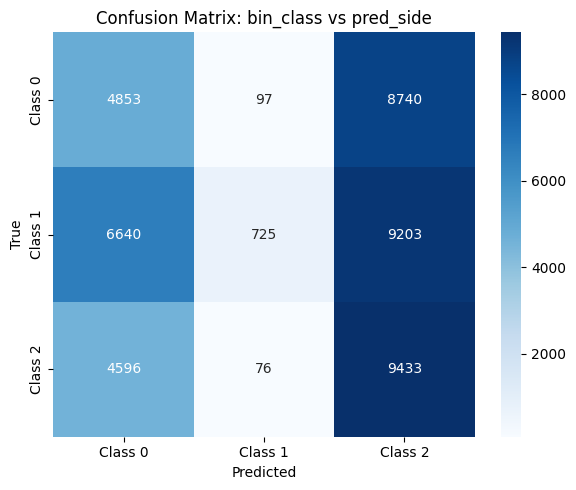

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = combined["bin_class"].astype(int)
y_pred = combined["pred_side"].astype(int)

# 計算混淆矩陣
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
labels = ["Class 0", "Class 1", "Class 2"]

# 繪圖
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix: bin_class vs pred_side")
plt.tight_layout()
plt.show()

## Apply Triple Barrier
We use daily volatility to calculate TP/SL, and we set our T1 as 1day

In [ ]:
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import pandas as pd

def applyPtSlOnT1(close,events,ptSl,molecule):
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_=events.loc[molecule]
    out=events_[['t1']].copy(deep=True)
    if ptSl[0]>0: pt=ptSl[0]*events_['trgt']
    else: pt=pd.Series(index=events.index) # NaNs
    if ptSl[1]>0: sl=-ptSl[1]*events_['trgt']
    else: sl=pd.Series(index=events.index) # NaNs
    for loc, t1 in events_['t1'].fillna(close.index[-1]).items():
        df0=close[loc:t1] # path prices
        df0=(df0/close[loc]-1)*events_.at[loc,'side'] # path returns
        out.loc[loc,'sl']=df0[df0<sl[loc]].index.min() # earliest stop loss
        out.loc[loc,'pt']=df0[df0>pt[loc]].index.min() # earliest profit taking
    return out


def parallel_apply(func, items, num_threads=4, **kwargs):
    def worker(molecule):
        return func(molecule=molecule, **kwargs)

    chunks = np.array_split(items, num_threads)
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        results = list(executor.map(worker, chunks))

    return pd.concat(results).sort_index()


def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads=4, t1=False, side=None):
    # Step 1: Filter targets
    trgt = trgt.loc[tEvents]
    trgt = trgt[trgt > minRet]

    # Step 2: Set vertical barrier (t1)
    if t1 is False:
        t1 = pd.Series(pd.NaT, index=tEvents)

    # Step 3: Build events DataFrame
    if side is None:
        side_, ptSl_ = pd.Series(1., index=trgt.index), [ptSl[0], ptSl[0]]
    else:
        side_, ptSl_ = side.loc[trgt.index], ptSl[:2]

    events = pd.concat({'t1': t1, 'trgt': trgt, 'side': side_}, axis=1).dropna(subset=['trgt'])

    # Step 4: Apply barriers in parallel
    df0 = parallel_apply(
        func=applyPtSlOnT1,
        items=events.index,
        num_threads=numThreads,
        close=close,
        events=events,
        ptSl=ptSl_
    )

    # Step 5: Choose the first touched barrier
    events['t1'] = df0.dropna(how='all').min(axis=1)
    if side is None:
        events = events.drop('side', axis=1)
    return events


In [ ]:
close = df['close']

t1 = close.index.searchsorted(t_events + pd.Timedelta(days=1))
t1 = t1[t1<close.shape[0]]
t1 = pd.Series(close.index[t1], index=t_events[:t1.shape[0]])

In [ ]:
%%time

events = getEvents(df['close'], t_events, [5e-3, 5e-3], trgt, 0, 8, t1=t1, side=sides)

In [ ]:
events

In [ ]:
def getBins(events, close, t1=None):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    -t1 is original vertical barrier series
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    # 1) prices aligned with events
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1'].values).drop_duplicates()
    px = close.reindex(px, method='bfill')
    # 2) create out object
    out = pd.DataFrame(index=events_.index)
    out['ret'] = px.loc[events_['t1'].values].values / px.loc[
        events_.index] - 1
    if 'side' in events_: out['ret'] *= events_['side']  # meta-labeling
    out['bin'] = np.sign(out['ret'])

    if 'side' not in events_:
        # only applies when not meta-labeling.
        # to update bin to 0 when vertical barrier is touched, we need the
        # original vertical barrier series since the events['t1'] is the time
        # of first touch of any barrier and not the vertical barrier
        # specifically. The index of the intersection of the vertical barrier
        # values and the events['t1'] values indicate which bin labels needs
        # to be turned to 0.
        vtouch_first_idx = events[events['t1'].isin(t1.values)].index
        out.loc[vtouch_first_idx, 'bin'] = 0.

    if 'side' in events_: out.loc[out['ret'] <= 0, 'bin'] = 0  # meta-labeling
    return out

In [ ]:
labels = getBins(events, close, t1=t1)
labels

In [ ]:
labeled_events = events.join(labels, how='inner')
labeled_events

## Save events to disk

In [ ]:
labeled_events.to_pickle(LABEL_FILE_PATH)